In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder


In [6]:
# Load the RecipeNLG dataset
file_path = '/kaggle/input/explore-recipe-nlg-dataset/recipe_df.csv'  # Update the path as needed
data = pd.read_csv(file_path)

# Display dataset structure
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231142 entries, 0 to 2231141
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   title        object
 2   ingredients  object
 3   directions   object
 4   link         object
 5   source       object
 6   NER          object
dtypes: int64(1), object(6)
memory usage: 119.2+ MB
None
   Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                            

In [7]:
# Clean the text data (ingredients and directions)
import re

def clean_text(text):
    text = re.sub(r'[^\w\s,]', '', str(text))  # Remove special characters
    return text.lower()

data['ingredients'] = data['ingredients'].apply(clean_text)
data['directions'] = data['directions'].apply(clean_text)

# Drop rows with missing or incomplete data
data.dropna(subset=['title', 'ingredients', 'directions'], inplace=True)


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with a custom tokenizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), token_pattern=None)

# Fit and transform the 'ingredients' column
ingredient_matrix = vectorizer.fit_transform(data['ingredients'])


In [13]:
import random

def recommend_recipes(data, keyword=None, ner_filter=None, top_n=5):
    # Filter by keyword in title, ingredients, or directions
    if keyword:
        data = data[
            data['title'].str.contains(keyword, case=False, na=False) |
            data['ingredients'].str.contains(keyword, case=False, na=False) |
            data['directions'].str.contains(keyword, case=False, na=False)
        ]
    
    # Filter by NER (e.g., vegan, gluten-free)
    if ner_filter:
        data = data[data['NER'].str.contains(ner_filter, case=False, na=False)]
    
    # Select top N random recipes
    recommendations = data.sample(n=min(top_n, len(data)), random_state=42)
    return recommendations[['title', 'ingredients', 'directions', 'link']]


In [39]:
def recommend_filtered_recipes(data, ner_filter=None, top_n=5):
    # Filter by NER (e.g., "vegan")
    if ner_filter:
        filtered_data = data[data['NER'].str.contains(ner_filter, case=False, na=False)]
    else:
        filtered_data = data

    # Randomly select top N recipes from the filtered dataset
    recommendations = filtered_data.sample(n=min(top_n, len(filtered_data)), random_state=42)
    return recommendations[['title', 'ingredients', 'directions', 'link']]


In [41]:
print(data.columns)  # Prints all column names in your dataset


Index(['title', 'ingredients', 'directions', 'link', 'ingredients_word_count'], dtype='object')


In [42]:
# Display unique terms from the 'ingredients' column that might act as filters
unique_ingredients = data['ingredients'].str.lower().unique()  # Convert to lowercase for case-insensitive matching
print(unique_ingredients[:100])  # Display first 100 unique ingredients (to avoid too many outputs)


['05 cups cherry tomatoes, 2 tablespoons vegan pesto, 1 wholegrain pitta bread'
 '1 12 cups plain nondairy milk, 1 cup water, 13 cup tamari, 1 12 cups nutritional yeast, 1 tablespoon paprika, 1 tablespoon garlic powder, 1 tablespoon salt, 4 ounces firm tofu, 1 cup refined coconut oil melted, 1 12 lbs pasta, 1 cup vegan cheese, shredded optional'
 '1 12 cups quickcooking rolled oats not instant, 1 cup whole wheat pastry flour, 1 cup walnuts, lightly toasted and chopped, 1 cup semisweet vegan chocolate chips, 12 teaspoon salt, 14 teaspoon baking soda, 12 cup canola oil, 12 cup pure maple syrup, 2 tablespoons water, 2 teaspoons vanilla extract'
 '1 12 cups brown sugar, 1 cup vegan margarine such as blue bonnetr light, 12 cup white sugar, 1 banana, mashed, 2 tablespoons vanilla extract, 1 14 teaspoons baking soda, 12 teaspoon salt, 2 teaspoons hot water, 3 cups glutenfree allpurpose baking flour, 2 teaspoons xanthan gum, 1 12 cups vegan semisweet chocolate chips such as trader joesr'
 '114

In [43]:
# Check if specific dietary terms are present in the ingredients column
dietary_keywords = ['vegan', 'gluten-free', 'dairy-free', 'nut-free', 'low-carb', 'keto', 'paleo', 'vegetarian']

# Loop through the dietary keywords and filter the recipes containing them
for keyword in dietary_keywords:
    filtered_recipes = data[data['ingredients'].str.contains(keyword, case=False, na=False)]
    print(f"Recipes containing '{keyword}':")
    print(filtered_recipes[['title', 'ingredients']].head())  # Display first few recipes with the keyword


Recipes containing 'vegan':
                                               title  \
0           Wholegrain Pitta With Tomatoes And Pesto   
1                          Vegan Macaroni and Cheese   
2                The Ultimate Chocolate-Chip Cookies   
3  Vegan Gluten-Free Chocolate Chip Cookies Witho...   
4                    Chocolate Chip Pumpkin Brownies   

                                         ingredients  
0  05 cups cherry tomatoes, 2 tablespoons vegan p...  
1  1 12 cups plain nondairy milk, 1 cup water, 13...  
2  1 12 cups quickcooking rolled oats not instant...  
3  1 12 cups brown sugar, 1 cup vegan margarine s...  
4  114 cup brown rice flour, 6 tablespoons coconu...  
Recipes containing 'gluten-free':
Empty DataFrame
Columns: [title, ingredients]
Index: []
Recipes containing 'dairy-free':
Empty DataFrame
Columns: [title, ingredients]
Index: []
Recipes containing 'nut-free':
Empty DataFrame
Columns: [title, ingredients]
Index: []
Recipes containing 'low-carb':
Empty Da

In [18]:
# Generate recommendations
recommendations = recommend_filtered_recipes(data, ner_filter='vegan', top_n=5)

# Check if recommendations are generated
if not recommendations.empty:
    # Save recommendations to a CSV file
    recommendations.to_csv('recommendations.csv', index=False)
    print("Recommendations saved to recommendations.csv")
else:
    print("No recommendations found for the given filter.")


Recommendations saved to recommendations.csv


In [21]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Generate a recipe
input_text = "Ingredients: chocolate, cheese, bread. Directions:"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
output = model.generate(input_ids, max_length=100, num_return_sequences=1)

generated_recipe = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_recipe)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Ingredients: chocolate, cheese, bread. Directions: Preheat oven to 350 degrees F. Line a baking sheet with parchment paper. In a large bowl, combine the flour, baking powder, baking soda, baking soda, baking soda mixture, and salt. In a separate bowl, combine the egg yolks, sugar, and salt. Add the flour mixture to the dry ingredients and mix well. Pour the mixture into the prepared baking sheet. Bake for 10-12 minutes, or until the edges


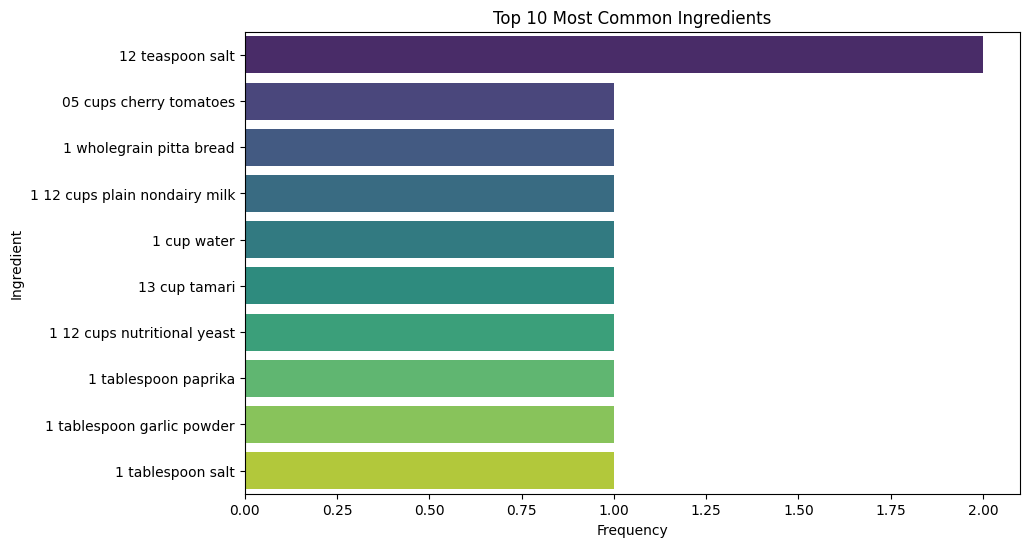

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split ingredients into individual items and count frequencies
ingredient_list = data['ingredients'].str.split(',').explode().str.strip().str.lower()
ingredient_counts = ingredient_list.value_counts().head(10)  # Top 10 most common ingredients

# Plot the ingredient frequency distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=ingredient_counts.values, y=ingredient_counts.index, palette='viridis')
plt.title('Top 10 Most Common Ingredients')
plt.xlabel('Frequency')
plt.ylabel('Ingredient')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


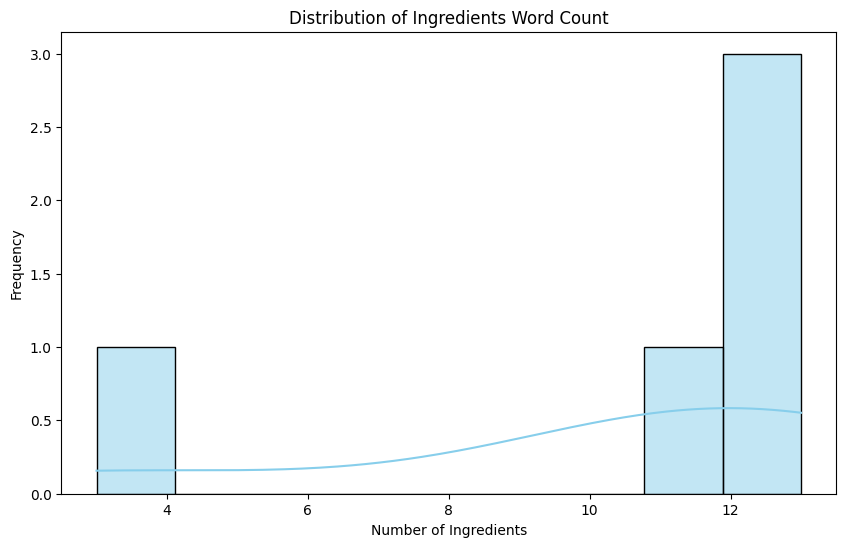

In [37]:
# Calculate the word count for the 'ingredients' column
data['ingredients_word_count'] = data['ingredients'].apply(lambda x: len(x.split(',')))

# Plot the distribution of word counts in ingredients
plt.figure(figsize=(10, 6))
sns.histplot(data['ingredients_word_count'], kde=True, color='skyblue')
plt.title('Distribution of Ingredients Word Count')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

